## scikit-learn sample_weight compliance investigative plots

This notebook runs compliance tests on a given scikit-learn estimators. This allows one to plot different features of the resulting predictions and scores with and without weights, so as to check weighted-repeated equivalence.

In [1]:
import sklearn

sklearn.show_versions()


System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:13:44) [Clang 16.0.6 ]
executable: /Users/shrutinath/micromamba/envs/scikit-learn/bin/python
   machine: macOS-14.3-arm64-arm-64bit

Python dependencies:
      sklearn: 1.7.dev0
          pip: 24.0
   setuptools: 75.8.0
        numpy: 2.0.0
        scipy: 1.14.0
       Cython: 3.0.10
       pandas: 2.2.2
   matplotlib: 3.9.0
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 8
         prefix: libopenblas
       filepath: /Users/shrutinath/micromamba/envs/scikit-learn/lib/libopenblas.0.dylib
        version: 0.3.27
threading_layer: openmp
   architecture: VORTEX

       user_api: openmp
   internal_api: openmp
    num_threads: 8
         prefix: libomp
       filepath: /Users/shrutinath/micromamba/envs/scikit-learn/lib/libomp.dylib
        version: None


In [19]:
from inspect import signature
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from sklearn.utils import all_estimators
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
import threadpoolctl

import sys
sys.path.insert(1,'../src')
from sample_weight_audit import check_weighted_repeated_estimator_fit_equivalence
from sample_weight_audit.sklearn_stochastic_params import STOCHASTIC_FIT_PARAMS

# HistGradientBoostingClassifier trashes the OpenMP thread pool on repeated
# small fits.
threadpoolctl.threadpool_limits(limits=1, user_api="openmp")
warnings.filterwarnings("ignore", category=RuntimeWarning)  # division by zero in AdaBoost
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # liblinear can fail to converge
warnings.filterwarnings("ignore", category=UserWarning)  # KBinsDiscretizer with collapsed bins

In [4]:
from sklearn.ensemble import BaggingRegressor

est_class = BaggingRegressor
est_name = est_class.__name__

In [5]:
N_STOCHASTIC_FITS = 100
N_STATISTICAL_TESTS = 58  # measured by running the script
BONFERRONI_CORRECTION = 1 / N_STATISTICAL_TESTS
TEST_THRESHOLD = 0.05 * BONFERRONI_CORRECTION



    
if "sample_weight" not in signature(est_class.fit).parameters:
    print(f"⚠ {est_name} does not support sample_weight")

try:
    if est_name == "CategoricalNB":
        # This estimator expects ordinal inputs so we need to discretize the input
        # features. This is not really valid but it's the best we can do while
        # keeping the dataset generation process common to all estimators of a
        # given type.
        est = Pipeline(
            steps=[
                (
                    "kbinsdiscretizer",
                    KBinsDiscretizer(
                        encode="ordinal", quantile_method="averaged_inverted_cdf"
                    ),
                ),
                ("est", est_class(**STOCHASTIC_FIT_PARAMS.get(est_class, {}))),
            ]
        )
    else:
        est = est_class(**STOCHASTIC_FIT_PARAMS.get(est_class, {}))
except TypeError as e:
    print(f"⚠ {est_name} failed to instantiate: {e}")

print(f"Evaluating {est}")
try:
    result = check_weighted_repeated_estimator_fit_equivalence(
        est,
        est_name,
        test_name="kstest",
        n_stochastic_fits=N_STOCHASTIC_FITS,
        random_state=0,
    )
    statistical_test_results = result
except Exception as e:
    print(f"❌ {est} error with: {e}")
    errors = (est, e)



Evaluating BaggingRegressor(estimator=Ridge())


100%|██████████| 100/100 [00:02<00:00, 49.98it/s]


# Make plots of scores

Text(0.5, 1.0, 'KS p-value: 4.528308394643339e-17')

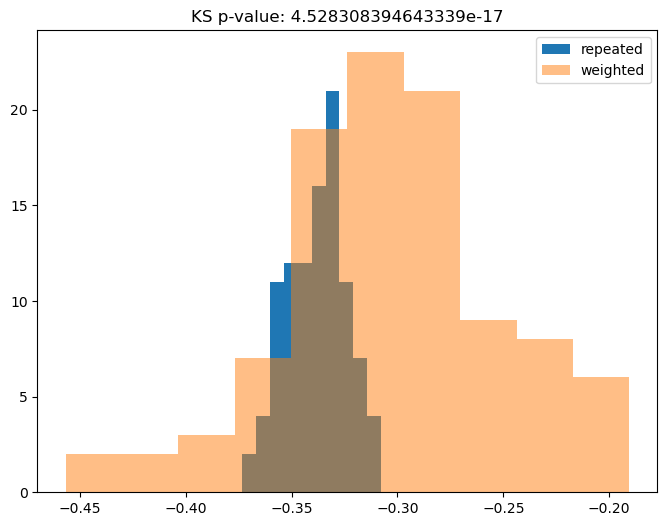

In [21]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

sample_position = 30

ax.hist(statistical_test_results.scores_repeated,label='repeated')
ax.hist(statistical_test_results.scores_weighted,alpha=0.5,label='weighted')
ax.legend()
ax.set_title(f'KS p-value: {statistical_test_results.pvalue}')

# Make plots of predictions

## Starting with overview of samples spaced at intervals of 5 (since test set is set to 100 this gives us 20 samples)

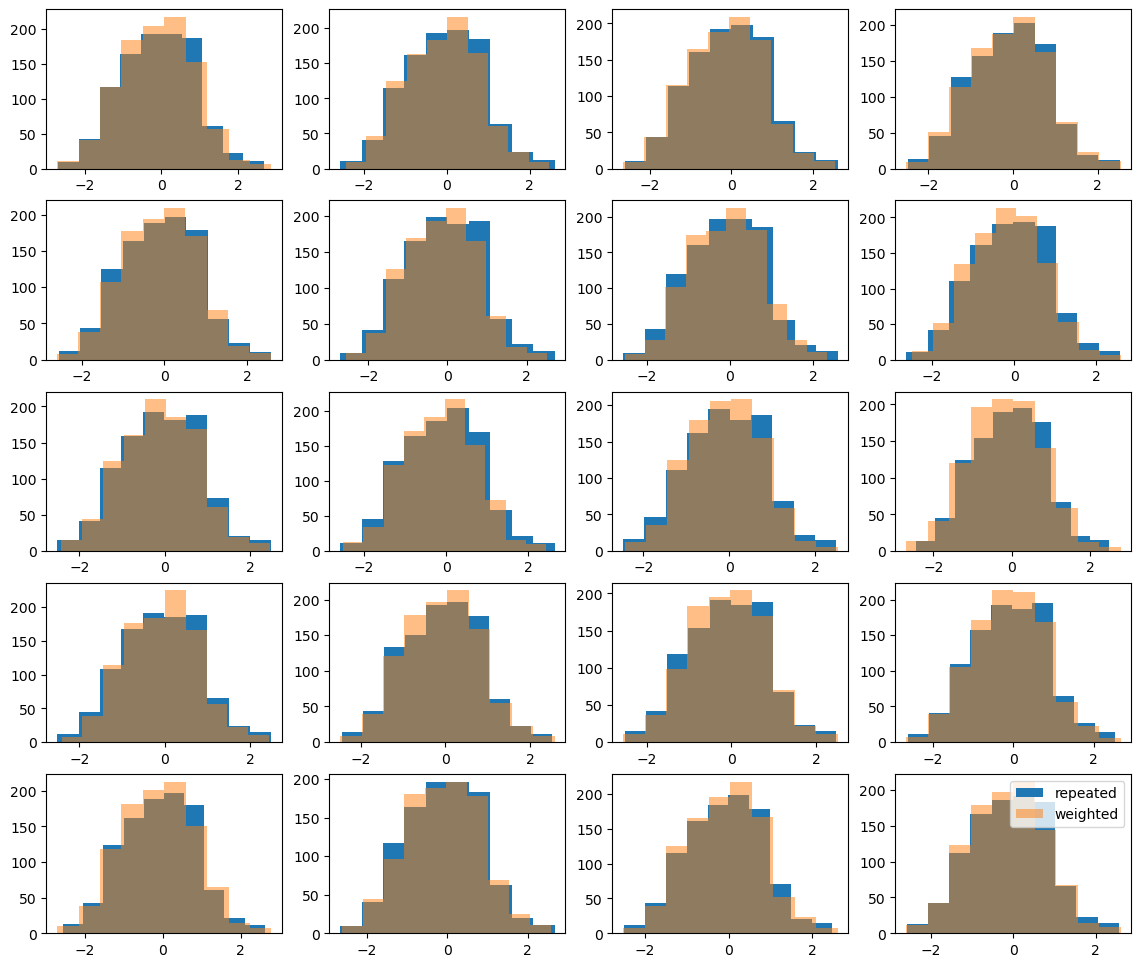

In [15]:
fig,axs = plt.subplots(5,4,figsize=(14,12))

j=0
for i,ax in enumerate(axs.flatten()):
    if i>0 and i%4==0:
        j+=1
    if i==len(axs.flatten())-1:
        ax.hist(statistical_test_results.predictions_repeated[i*5,:].flatten(),label='repeated')
        ax.hist(statistical_test_results.predictions_weighted[i*5,:].flatten(),alpha=0.5,label='weighted')
        ax.legend()
    else:
        ax.hist(statistical_test_results.predictions_repeated[i*5,:].flatten())
        ax.hist(statistical_test_results.predictions_weighted[i*5,:].flatten(),alpha=0.5)


## Zooming into individual samples

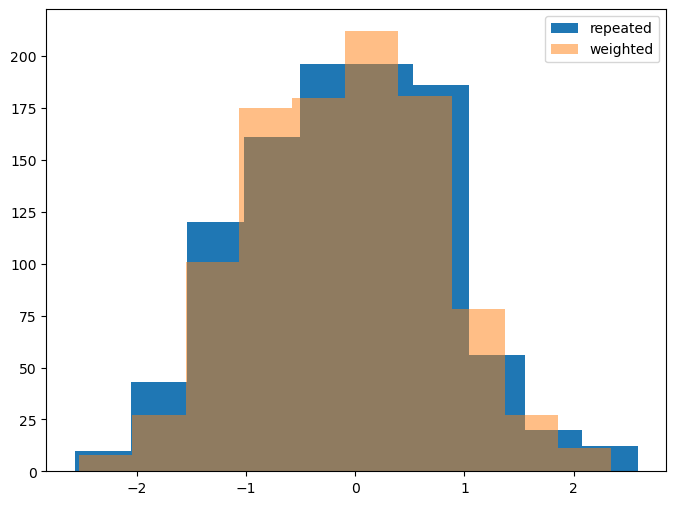

In [18]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

sample_position = 30

ax.hist(statistical_test_results.predictions_repeated[sample_position,:].flatten(),label='repeated')
ax.hist(statistical_test_results.predictions_weighted[sample_position,:].flatten(),alpha=0.5,label='weighted')
ax.legend()